In [9]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Concatenate, Masking
from tensorflow.keras.models import Model


2025-03-03 09:17:01.482823: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 09:17:01.602453: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 09:17:01.603665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-03 09:17:02.810361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:


# Folder path where the pickle files are stored
folder_path = "/home/q674749/workspace/thesis_work/rat25-15.4.1/perception/BERT_NOTEBOOK/final_leading_object_data"

# List to hold all DataFrames
dfs = []

# Loop through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".p") and not file.startswith("combined_file"):  # Skip combined files if they exist
        file_path = os.path.join(folder_path, file)
        
        # Load each Pickle file and append to list
        df = pd.read_pickle(file_path)
        dfs.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame as a new Pickle file
combined_pickle_path = os.path.join(folder_path, "combined_file_new.pkl")
combined_df.to_pickle(combined_pickle_path)

print(f"✅ Combined Pickle file saved as: {combined_pickle_path}")

✅ Combined Pickle file saved as: /home/q674749/workspace/thesis_work/rat25-15.4.1/perception/BERT_NOTEBOOK/final_leading_object_data/combined_file_new.pkl


In [5]:


# Load the combined Pickle file
combined_pickle_path = "/home/q674749/workspace/thesis_work/rat25-15.4.1/perception/BERT_NOTEBOOK/final_leading_object_data/combined_file_new.pkl"
df = pd.read_pickle(combined_pickle_path)

# Print dataset information
print("✅ Combined Dataset Loaded Successfully!")
print("Dataset Shape:", df.shape)  # Number of rows and columns
print("Dataset Columns:", df.columns)  # List of all column names

# Show first few rows
print("\nFirst 5 Rows:")
print(df.head())

✅ Combined Dataset Loaded Successfully!
Dataset Shape: (38794, 29)
Dataset Columns: Index(['timestamp', 'rcs', 'distance', 'angleAzimuth', 'angleElevation',
       'x_det', 'y_det', 'z', 'radialVelocity', 'objectID',
       'radialVelocityDomainMax', 'orientation', 'x_obj', 'y_obj',
       'width_edge_mean', 'length_edge_mean', 'object_id', 'header.origin.x',
       'header.origin.y', 'header.origin.z', 'header.origin.roll',
       'header.origin.pitch', 'header.origin.yaw', 'reference_point',
       'yaw_rate', 'ego_speed', 'centroid_x', 'centroid_y',
       'is_valid_detection'],
      dtype='object')

First 5 Rows:
      timestamp                                                rcs  \
0  2.746754e+07  [-18, -32, -25, -21, -32, -29, -36, -37, -31, ...   
1  2.746755e+07  [-23, -23, -22, -7, -28, -39, -25, -26, -23, -...   
2  2.746755e+07  [-35, -28, -25, -26, -35, -40, -28, -24, -32, ...   
3  2.746755e+07  [-34, -23, -24, -27, -33, -34, -24, -26, -31, ...   
4  2.746755e+07  [-28, -

In [6]:
# Check length consistency across detection features
df["x_det_len"] = df["x_det"].apply(len)
df["y_det_len"] = df["y_det"].apply(len)
df["radialVelocity_len"] = df["radialVelocity"].apply(len)
df["rcs_len"] = df["rcs"].apply(len)

# Find rows where lengths are inconsistent
inconsistent_rows = df[
    (df["x_det_len"] != df["y_det_len"]) |
    (df["x_det_len"] != df["radialVelocity_len"]) |
    (df["x_det_len"] != df["rcs_len"])
]

# Print results
print("✅ Total Rows in Dataset:", len(df))
print("❗ Rows with inconsistent feature lengths:", len(inconsistent_rows))

# If inconsistencies exist, show a few samples
if not inconsistent_rows.empty:
    print("\nSample Inconsistent Rows:")
    print(inconsistent_rows[["x_det_len", "y_det_len", "radialVelocity_len", "rcs_len"]].head())

✅ Total Rows in Dataset: 38794
❗ Rows with inconsistent feature lengths: 0


In [7]:


# Define relevant columns
relevant_columns = [
    "x_det", "y_det", "radialVelocity", "rcs",  # Detection features
    "ego_speed",  # Scalar input
    "centroid_x", "centroid_y", "orientation", "width_edge_mean", "length_edge_mean"  # Labels
]

# Keep only relevant columns
df = df[relevant_columns]

def format_features(row):
    """Ensures correct label formats and scalar float values. No padding applied."""
    
    # Convert NumPy arrays to lists (Fix for broadcasting issue)
    row["x_det"] = row["x_det"].tolist() if isinstance(row["x_det"], np.ndarray) else row["x_det"]
    row["y_det"] = row["y_det"].tolist() if isinstance(row["y_det"], np.ndarray) else row["y_det"]
    row["radialVelocity"] = row["radialVelocity"].tolist() if isinstance(row["radialVelocity"], np.ndarray) else row["radialVelocity"]
    row["rcs"] = row["rcs"].tolist() if isinstance(row["rcs"], np.ndarray) else row["rcs"]

    # Convert labels to floats (Extract first value if it's a list)
    def extract_float(value):
        """If value is a list, extract first element; otherwise, return float."""
        if isinstance(value, list):
            return float(value[0]) if value else 0.0  # Handle empty lists safely
        return float(value)

    row["centroid_x"] = extract_float(row["centroid_x"])
    row["centroid_y"] = extract_float(row["centroid_y"])
    row["orientation"] = extract_float(row["orientation"])
    row["width_edge_mean"] = extract_float(row["width_edge_mean"])
    row["length_edge_mean"] = extract_float(row["length_edge_mean"])

    # Ensure ego_speed is float (already correct, but apply float() for safety)
    row["ego_speed"] = float(row["ego_speed"])

    return row

# Apply formatting to all rows (without padding)
df = df.apply(lambda row: format_features(row), axis=1)

print("✅ Total Rows in Dataset:", len(df))
print("✅ Kept only relevant columns. New shape:", df.shape)
print("\n✅ Sample formatted labels and scalar feature:")
print(df[["centroid_x", "centroid_y", "orientation", "width_edge_mean", "length_edge_mean", "ego_speed"]].head())

✅ Total Rows in Dataset: 38794
✅ Kept only relevant columns. New shape: (38794, 10)

✅ Sample formatted labels and scalar feature:
   centroid_x  centroid_y  orientation  width_edge_mean  length_edge_mean  \
0  103.434998      -1.815     0.062416             0.25              0.25   
1   52.509998       2.410     2.324243             1.20              0.68   
2   52.014997       2.420    -0.356086             1.20              0.69   
3   51.734999       2.400     3.141304             1.20              0.81   
4   51.315001       2.550    -0.296738             1.20              0.77   

   ego_speed  
0   9.703125  
1  20.734375  
2  20.671875  
3  20.609375  
4  20.468750  


In [8]:
from sklearn.model_selection import train_test_split

# Split data into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 80% train, 20% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split 20% into 10% val, 10% test

# Print dataset sizes
print(f"✅ Training set: {len(train_df)} rows")
print(f"✅ Validation set: {len(val_df)} rows")
print(f"✅ Test set: {len(test_df)} rows")

✅ Training set: 31035 rows
✅ Validation set: 3879 rows
✅ Test set: 3880 rows


In [10]:

class RadarPointNetPlusPlus(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        # Masking Layer (Ignores Padded Values)
        self.masking = Masking(mask_value=0.0)

        # Shared MLP for per-point feature extraction
        self.shared_mlp = tf.keras.Sequential([
            Dense(64, activation="relu"),
            Dense(128, activation="relu"),
            Dense(256, activation="relu")
        ])
        
        # Feature Aggregation (Global Pooling)
        self.global_pool = Lambda(lambda x: tf.reduce_max(x, axis=1))

        # Fully Connected Layers for Final Prediction
        self.fc = tf.keras.Sequential([
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(5)  # Output: [centroid_x, centroid_y, orientation, width, length]
        ])
        
    def call(self, inputs):
        """Forward pass through the model."""
        detections = inputs["detections"]  # Expected: (batch_size, N_detections, 4)
        ego_speed = inputs["ego_speed"]    # Expected: (batch_size, 1)

        # Check if detections are RaggedTensor and convert only if necessary
        if isinstance(detections, tf.RaggedTensor):
            detections = detections.to_tensor()  # Convert to dense tensor only if ragged

        # Apply Masking to ignore padding
        masked_detections = self.masking(detections)

        # Apply Shared MLP to each detection
        point_features = self.shared_mlp(masked_detections)  # Shape: (batch_size, N_detections, 256)

        # Feature Aggregation (Max Pooling over detections)
        global_features = self.global_pool(point_features)  # Shape: (batch_size, 256)

        # Concatenate with ego_speed
        combined_features = Concatenate()([global_features, ego_speed])  # Shape: (batch_size, 257)

        # Fully Connected Layers for Final Prediction
        outputs = self.fc(combined_features)  # Shape: (batch_size, 5)

        return outputs

print("✅ Model defined successfully!")

✅ Model defined successfully!


In [11]:
# Initialize the model
model = RadarPointNetPlusPlus()

# Compile the model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"]
)

print("✅ Model compiled successfully!")

✅ Model compiled successfully!


2025-03-03 09:17:15.329228: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
# new start

In [14]:
import tensorflow as tf
tf.keras.backend.clear_session()
print("✅ TensorFlow session cleared. Model reset!")

✅ TensorFlow session cleared. Model reset!


In [15]:
# Recreate the model
model = RadarPointNetPlusPlus()

# Compile the model again
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"]
)

print("✅ Model reinitialized and compiled!")

✅ Model reinitialized and compiled!


In [16]:
import tensorflow as tf

def preprocess(row):
    """Converts a single row into the model input format with RaggedTensors."""
    
    # Convert detection features into a single RaggedTensor (N_detections x 4)
    detections = tf.ragged.constant(
        list(zip(row["x_det"], row["y_det"], row["radialVelocity"], row["rcs"])), 
        dtype=tf.float32
    )  # Keeps variable-length detections

    # Scalar input: ego_speed (Convert to tensor)
    ego_speed_tensor = tf.convert_to_tensor([row["ego_speed"]], dtype=tf.float32)

    # Labels (Ground truth outputs)
    labels = [
        row["centroid_x"],
        row["centroid_y"],
        row["orientation"],
        row["width_edge_mean"],
        row["length_edge_mean"]
    ]
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

    return {"detections": detections, "ego_speed": ego_speed_tensor}, labels_tensor


# def create_dataset(df, batch_size=32):
#     """Convert a Pandas DataFrame into a TensorFlow Dataset using RaggedTensors."""
#     dataset = tf.data.Dataset.from_generator(
#         lambda: (preprocess(row) for _, row in df.iterrows()),
#         output_signature=(
#             {
#                 "detections": tf.RaggedTensorSpec(shape=[None, 4], dtype=tf.float32),  # Variable-length input
#                 "ego_speed": tf.TensorSpec(shape=[1], dtype=tf.float32)
#             },
#             tf.TensorSpec(shape=[5], dtype=tf.float32)  # Labels: [centroid_x, centroid_y, orientation, width, length]
#         )
#     )
#     return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# print("✅ `create_dataset()` function restored successfully!")'

In [17]:
def create_dataset(df, batch_size=32):
    """Convert DataFrame to a TensorFlow Dataset and ensure it repeats across epochs."""
    
    # Convert the DataFrame into a list first (so TensorFlow can infer length)
    data_list = list(df.iterrows())

    dataset = tf.data.Dataset.from_generator(
        lambda: (preprocess(row[1]) for row in data_list),  # row[1] gets the actual data
        output_signature=(
            {
                "detections": tf.RaggedTensorSpec(shape=[None, 4], dtype=tf.float32),  # Variable-length input
                "ego_speed": tf.TensorSpec(shape=[1], dtype=tf.float32)
            },
            tf.TensorSpec(shape=[5], dtype=tf.float32)  # Labels: [centroid_x, centroid_y, orientation, width, length]
        )
    )
    
    return dataset.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)  # <== Add .repeat() here

print("✅ Dataset function updated to avoid running out of data!")

✅ Dataset function updated to avoid running out of data!


In [18]:
train_dataset = create_dataset(train_df, batch_size=32)
val_dataset = create_dataset(val_df, batch_size=32)
test_dataset = create_dataset(test_df, batch_size=32)

print("✅ Dataset recreated successfully!")

✅ Dataset recreated successfully!


In [19]:
import tensorflow as tf

# Clear the current TensorFlow session
tf.keras.backend.clear_session()

print("✅ TensorFlow session cleared. Old weights removed!")

✅ TensorFlow session cleared. Old weights removed!


In [20]:
# Recreate the model
model = RadarPointNetPlusPlus()

# Compile the model again
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"]
)

print("✅ Model reinitialized and compiled from scratch!")

✅ Model reinitialized and compiled from scratch!


In [21]:
train_dataset = create_dataset(train_df, batch_size=32)
val_dataset = create_dataset(val_df, batch_size=32)
test_dataset = create_dataset(test_df, batch_size=32)

print("✅ Dataset recreated successfully!")

✅ Dataset recreated successfully!


In [22]:
# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,  # Stops if validation loss does not improve for 5 epochs
    restore_best_weights=True  # Ensures we use the best-performing weights
)

print("✅ Early stopping callback defined!")

✅ Early stopping callback defined!


In [23]:
# Create checkpoint callback to save model for later use
checkpoint_path = "/home/q674749/workspace/thesis_work/rat25-15.4.1/perception/BERT_NOTEBOOK/checkpoints/model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,  # Save only the model weights
    monitor="val_loss",  # Save the model weights with the best validation loss
    save_best_only=True  # Only keep the best model weights on file
)

print("✅ Model checkpoint callback created successfully!")

✅ Model checkpoint callback created successfully!


In [24]:
import math

# Define steps per epoch
train_steps_per_epoch = math.ceil(len(train_df) / 32)
val_steps_per_epoch = math.ceil(len(val_df) / 32)

# Train the model with early stopping and checkpointing
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, checkpoint_callback],  # Added checkpoint callback
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch
)

print("✅ Training restarted with full dataset coverage per epoch and model checkpointing enabled!")

Epoch 1/50
970/970 [==============================] - 590s 606ms/step - loss: 473.1967 - mae: 9.2415 - val_loss: 154.5838 - val_mae: 5.7310
Epoch 2/50
970/970 [==============================] - 599s 619ms/step - loss: 93.9755 - mae: 4.4980 - val_loss: 50.0970 - val_mae: 3.5355
Epoch 3/50
970/970 [==============================] - 618s 637ms/step - loss: 34.3604 - mae: 2.9726 - val_loss: 17.5795 - val_mae: 2.3131
Epoch 4/50
970/970 [==============================] - 645s 666ms/step - loss: 18.0816 - mae: 2.2985 - val_loss: 11.0795 - val_mae: 1.9151
Epoch 5/50
970/970 [==============================] - 675s 696ms/step - loss: 10.5893 - mae: 1.8320 - val_loss: 4.9564 - val_mae: 1.4005
Epoch 6/50
970/970 [==============================] - 742s 765ms/step - loss: 12.7029 - mae: 1.9122 - val_loss: 5.1528 - val_mae: 1.3779
Epoch 7/50
970/970 [==============================] - 867s 894ms/step - loss: 14.8916 - mae: 1.9061 - val_loss: 13.1623 - val_mae: 1.9882
Epoch 8/50
970/970 [==============

In [25]:
# Load best model weights
model.load_weights(checkpoint_path)

print("✅ Best model weights restored successfully!")

✅ Best model weights restored successfully!


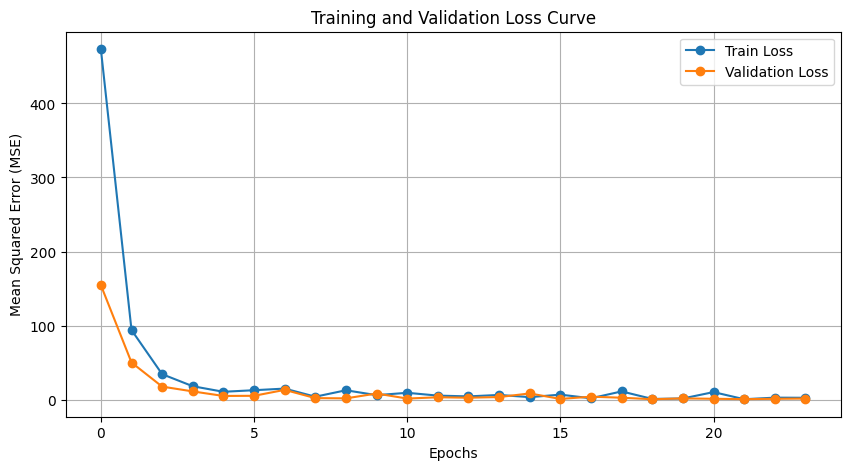

In [26]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss", marker="o")
plt.plot(history.history["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

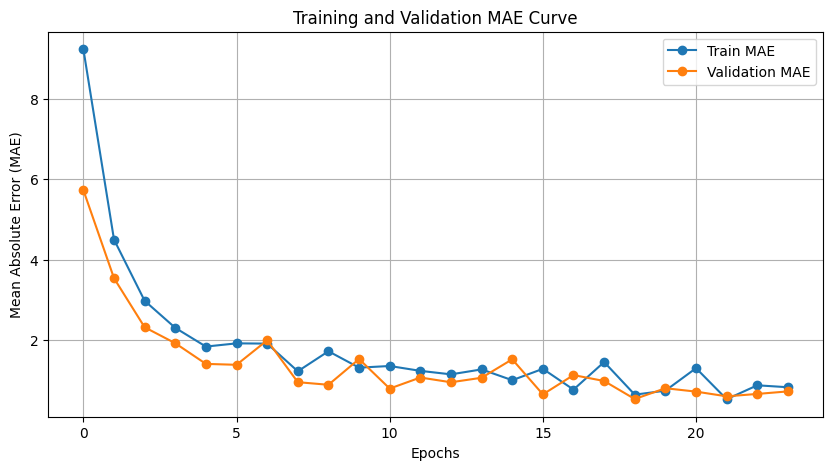

In [27]:
# Plot training and validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history["mae"], label="Train MAE", marker="o")
plt.plot(history.history["val_mae"], label="Validation MAE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Training and Validation MAE Curve")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_box(centroid_x, centroid_y, orientation, width, length, color='b', label=None):
    """Plots a bounding box using centroid, orientation, width, and length."""
    
    # Compute half width and half length
    half_width = width / 2.0
    half_length = length / 2.0
    
    # Compute corner points (before rotation)
    corners = np.array([
        [-half_length, -half_width],  # Bottom-left
        [-half_length, half_width],   # Top-left
        [half_length, half_width],    # Top-right
        [half_length, -half_width],   # Bottom-right
        [-half_length, -half_width]   # Close the rectangle
    ])
    
    # Rotation matrix (to rotate the box)
    rotation_matrix = np.array([
        [np.cos(orientation), -np.sin(orientation)],
        [np.sin(orientation), np.cos(orientation)]
    ])
    
    # Rotate and translate the corners
    rotated_corners = np.dot(corners, rotation_matrix.T) + np.array([centroid_x, centroid_y])
    
    # Plot the bounding box
    plt.plot(rotated_corners[:, 0], rotated_corners[:, 1], color=color, linewidth=2, label=label)

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 5 indices from the test dataset
random_indices = np.random.choice(len(test_df), size=5, replace=False)

print(f"✅ Selected Radar Cycle Indices: {random_indices}")

✅ Selected Radar Cycle Indices: [ 986  458 1003 1035  596]


In [38]:
def create_dataset(df, batch_size=32, is_training=True):
    """Convert DataFrame to a TensorFlow Dataset and ensure it does not repeat for evaluation."""
    
    # Convert DataFrame into a list first (so TensorFlow can infer length)
    data_list = list(df.iterrows())

    dataset = tf.data.Dataset.from_generator(
        lambda: (preprocess(row[1]) for row in data_list),  # row[1] gets the actual data
        output_signature=(
            {
                "detections": tf.RaggedTensorSpec(shape=[None, 4], dtype=tf.float32),  # Variable-length input
                "ego_speed": tf.TensorSpec(shape=[1], dtype=tf.float32)
            },
            tf.TensorSpec(shape=[5], dtype=tf.float32)  # Labels: [centroid_x, centroid_y, orientation, width, length]
        )
    )
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.repeat()  # Only repeat for training, NOT for testing!

    return dataset

# Create datasets
train_dataset = create_dataset(train_df, batch_size=32, is_training=True)  # Training needs repeat
val_dataset = create_dataset(val_df, batch_size=32, is_training=False)  # Validation doesn't need repeat
test_dataset = create_dataset(test_df, batch_size=32, is_training=False)  # Testing should not repeat

print("✅ Dataset function updated to prevent infinite test dataset!")

✅ Dataset function updated to prevent infinite test dataset!


In [46]:
# Extract selected samples from test dataset
test_subset = test_df.iloc[random_indices]

# Convert test subset into a dataset (without repeat)
test_subset_dataset = create_dataset(test_subset, batch_size=1, is_training=False)

# Define `steps=5` to process exactly 5 radar cycles
y_pred_subset = model.predict(test_subset_dataset, steps=10)

print("✅ Predictions completed for selected radar cycles!")

10/10 [==============================] - 0s 21ms/step
✅ Predictions completed for selected radar cycles!


In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_box(centroid_x, centroid_y, orientation, width, length, color='b', label=None):
    """Plots a bounding box using centroid, orientation, width, and length."""
    
    # Compute half width and half length
    half_width = width / 2.0
    half_length = length / 2.0
    
    # Compute corner points (before rotation)
    corners = np.array([
        [-half_length, -half_width],  # Bottom-left
        [-half_length, half_width],   # Top-left
        [half_length, half_width],    # Top-right
        [half_length, -half_width],   # Bottom-right
        [-half_length, -half_width]   # Close the rectangle
    ])
    
    # Rotation matrix (to rotate the box)
    rotation_matrix = np.array([
        [np.cos(orientation), -np.sin(orientation)],
        [np.sin(orientation), np.cos(orientation)]
    ])
    
    # Rotate and translate the corners
    rotated_corners = np.dot(corners, rotation_matrix.T) + np.array([centroid_x, centroid_y])
    
    # Plot the bounding box
    plt.plot(rotated_corners[:, 0], rotated_corners[:, 1], color=color, linewidth=2, label=label)

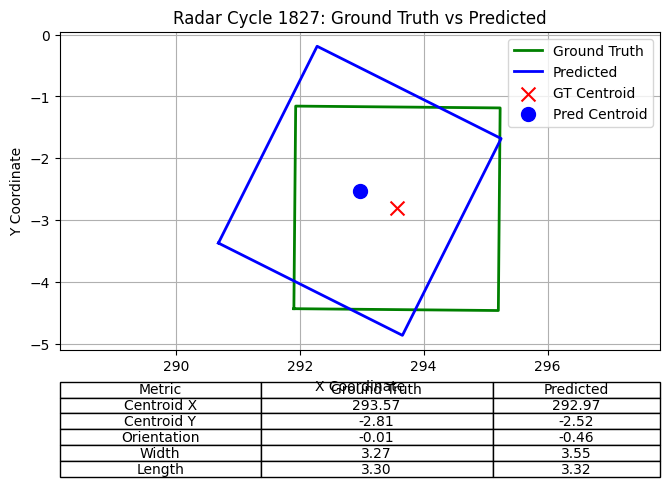

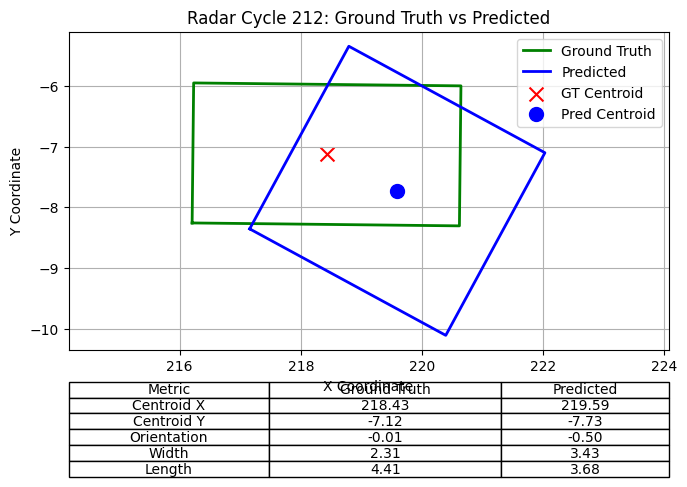

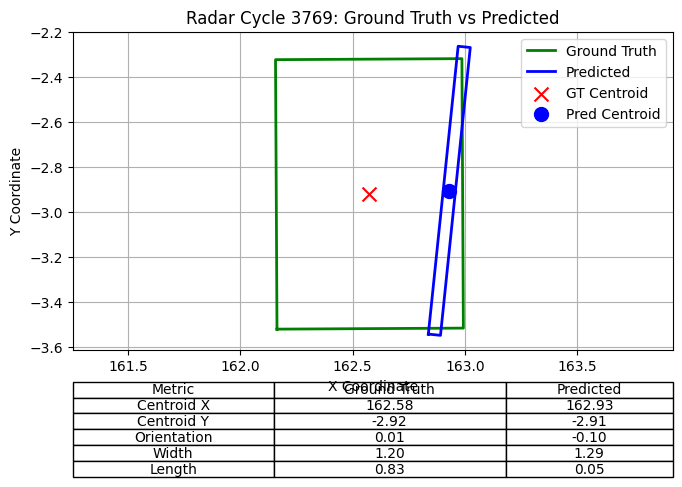

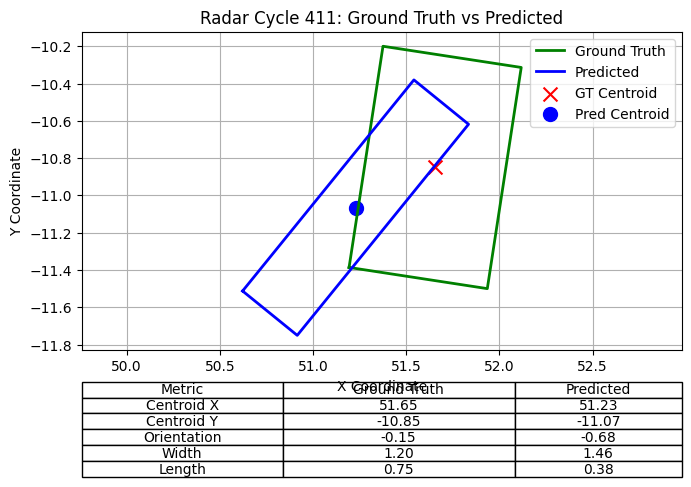

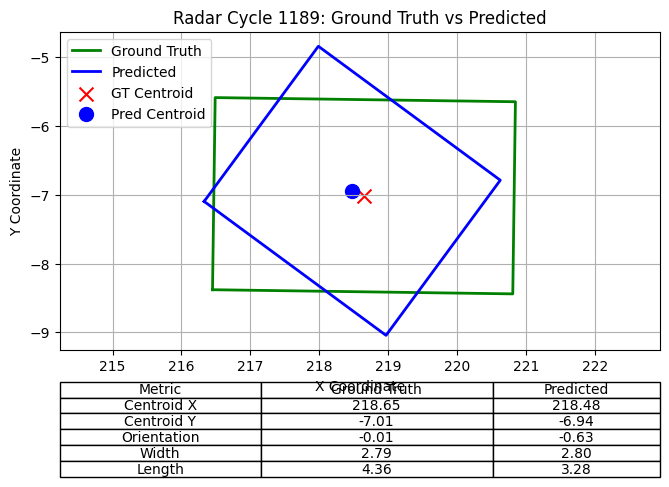

IndexError: single positional indexer is out-of-bounds

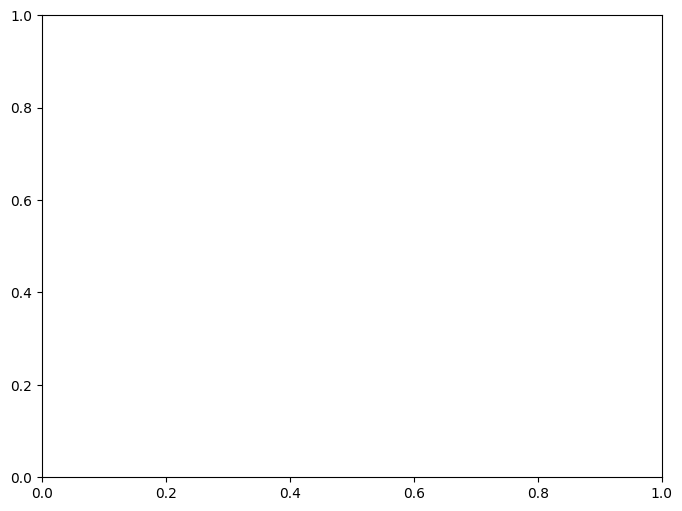

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seed for consistent visualization
random.seed(42)
np.random.seed(42)

# Randomly select 5 radar cycles
random_indices = np.random.choice(len(test_df), size=10, replace=False)

# Compute min and max values for x and y across selected samples (for consistent scale)
x_min = test_subset["centroid_x"].min() - 2
x_max = test_subset["centroid_x"].max() + 2
y_min = test_subset["centroid_y"].min() - 2
y_max = test_subset["centroid_y"].max() + 2

# Iterate through 5 selected radar cycles
for i, idx in enumerate(random_indices):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Ground truth values
    gt_centroid_x = test_subset.iloc[i]["centroid_x"]
    gt_centroid_y = test_subset.iloc[i]["centroid_y"]
    gt_orientation = test_subset.iloc[i]["orientation"]
    gt_width = test_subset.iloc[i]["width_edge_mean"]
    gt_length = test_subset.iloc[i]["length_edge_mean"]

    # Predicted values
    pred_centroid_x, pred_centroid_y, pred_orientation, pred_width, pred_length = y_pred_subset[i]

    # Plot ground truth bounding box
    plot_box(gt_centroid_x, gt_centroid_y, gt_orientation, gt_width, gt_length, color='g', label='Ground Truth')

    # Plot predicted bounding box
    plot_box(pred_centroid_x, pred_centroid_y, pred_orientation, pred_width, pred_length, color='b', label='Predicted')

    # Plot ground truth centroid as a cross ('x')
    ax.scatter(gt_centroid_x, gt_centroid_y, color='red', marker='x', s=100, label='GT Centroid')

    # Plot predicted centroid as a dot ('o')
    ax.scatter(pred_centroid_x, pred_centroid_y, color='blue', marker='o', s=100, label='Pred Centroid')

    # Set dynamic axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Customize the plot
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(f'Radar Cycle {idx + 1}: Ground Truth vs Predicted')
    ax.legend()
    ax.grid()
    ax.axis('equal')  # Maintain aspect ratio

    # Create a table with original & predicted values
    table_data = [
        ["Metric", "Ground Truth", "Predicted"],
        ["Centroid X", f"{gt_centroid_x:.2f}", f"{pred_centroid_x:.2f}"],
        ["Centroid Y", f"{gt_centroid_y:.2f}", f"{pred_centroid_y:.2f}"],
        ["Orientation", f"{gt_orientation:.2f}", f"{pred_orientation:.2f}"],
        ["Width", f"{gt_width:.2f}", f"{pred_width:.2f}"],
        ["Length", f"{gt_length:.2f}", f"{pred_length:.2f}"],
    ]

    # Place table outside the plot (below)
    table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='bottom', bbox=[0.0, -0.4, 1.0, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([0, 1, 2])

    # Adjust layout to avoid overlapping
    plt.subplots_adjust(left=0.15, bottom=0.35)  # More space for table below the graph
    plt.show()